In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Measles/nigeria.csv')
data.head()


,Year-Month,Cases
0,2011-1,4539
1,2011-2,4025
2,2011-3,4533
3,2011-4,2520
4,2011-5,1057


In [4]:
data.shape

(159, 2)

In [5]:
data.columns

Index(['Year-Month', 'Cases'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year-Month  159 non-null    object
 1   Cases       159 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ KB


In [7]:
data.describe()

,Cases
count,159.00
mean,1375.16
std,2191.36
min,12.00
25%,244.50
50%,687.00
75%,1529.00
max,17797.00


In [8]:
data['Date'] = pd.to_datetime(data['Year-Month'])
data = data.drop(columns = 'Year-Month')
data = data.set_index('Date')
data = data.rename(columns = {'Cases':'Cases'})
data.head()

,Cases
Date,
2011-01-01,4539
2011-02-01,4025
2011-03-01,4533
2011-04-01,2520
2011-05-01,1057


In [9]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
def tsplot(y, lags=24, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

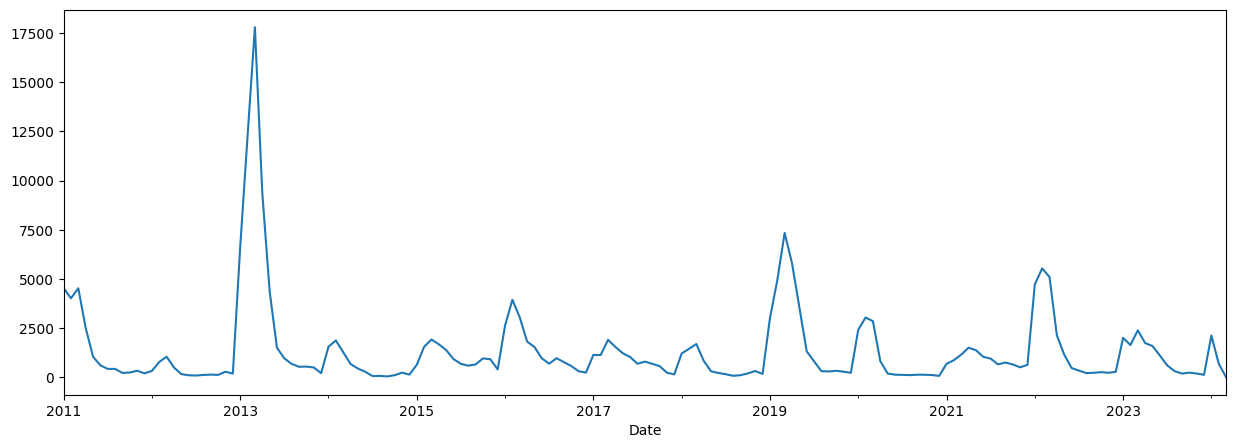

In [11]:
plt.figure(figsize = (15,5))
data['Cases'].plot();

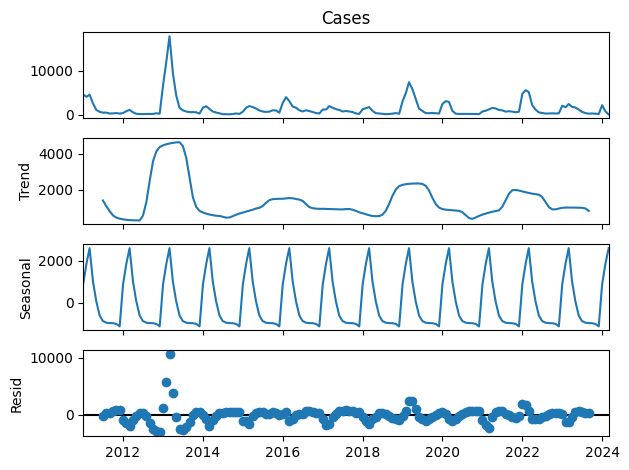

In [13]:
decomposition = sm.tsa.seasonal_decompose(data['Cases'],period = 12, model = 'additive').plot()
plt.show()

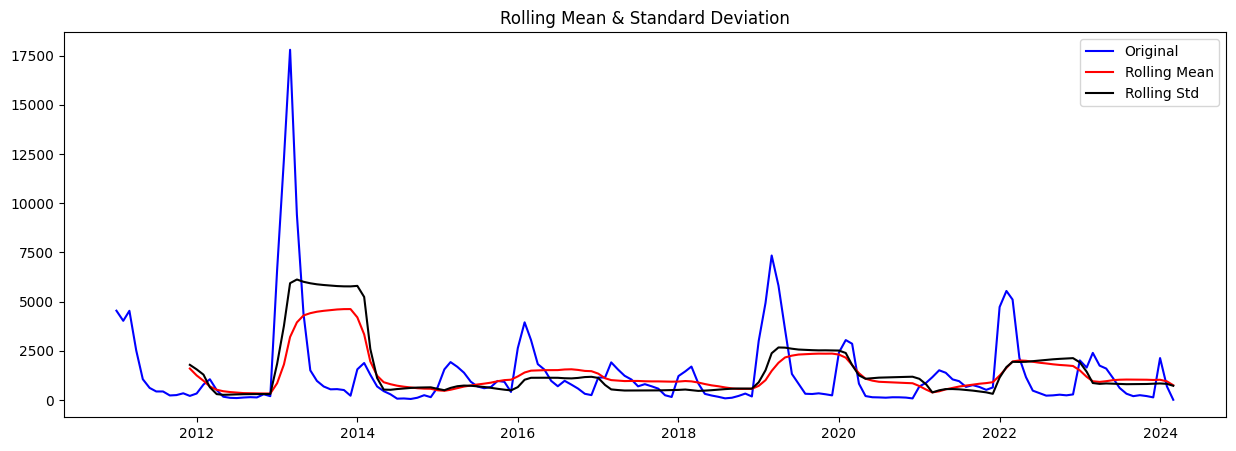

Results of Dickey-Fuller Test:
Test Statistic                 -5.51
p-value                         0.00
#Lags Used                      4.00
Number of Observations Used   154.00
Critical Value (1%)            -3.47
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [14]:
test_stationarity(data['Cases'])

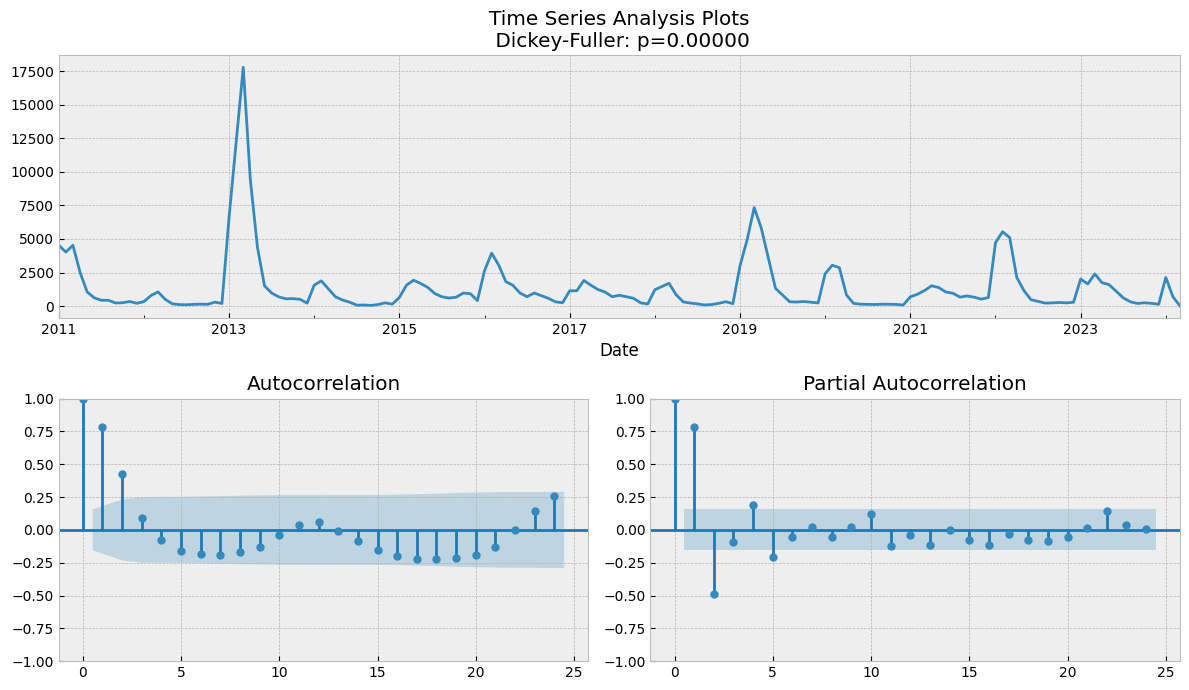

In [15]:
tsplot(data['Cases'])

In [16]:
import numpy as np
from statsmodels.tsa.stattools import kpss


# Perform KPSS test
kpss_stat, p_value, lags, critical_values = kpss(data['Cases'])

# Print the results
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Critical Values: {critical_values}')

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: The series is not stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")

KPSS Statistic: 0.10949435334458267
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject the null hypothesis: The series is stationary.


<ipython-input-16-a7f5dbdcd447>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(data['Cases'])


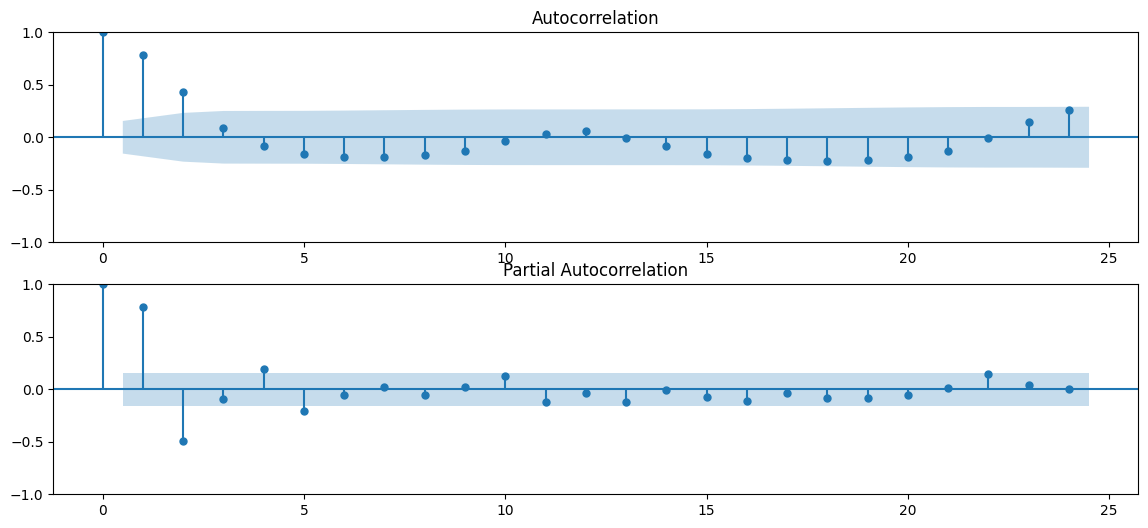

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(data, lags=24, ax=ax1)
ax2 = plot_pacf(data, lags=24, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

In [18]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.4 MB/s eta 0:00:00


In [21]:
train = data.iloc[0:147]
test = data.iloc[147:]

In [24]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
#Train/Test split
#Running the auto_arima
auto_model = pm.auto_arima(y=train["Cases"], start_p=0, start_q=0, max_p=15,
                           max_q=15,
                            m=12, max_order=15,
                           trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2694.948, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2691.195, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2545.498, Time=0.63 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2586.643, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2738.631, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2548.329, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2536.778, Time=2.04 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2688.219, Time=0.52 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2495.219, Time=7.76 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=2503.623, Time=0.22 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=2480.247, Time=2.13 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=2505.450, Time=0.18 sec
 ARIMA(2,0,0)(2,0,2)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  147
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 12)   Log Likelihood               -1233.123
Date:                              Fri, 19 Jul 2024   AIC                           2480.247
Time:                                      21:50:01   BIC                           2501.180
Sample:                                  01-01-2011   HQIC                          2488.752
                                       - 03-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.7303     32.220      0.612      0.540     -43.420      82.881
ar.L1          1.2043      0.034     34.920      0.000       1.137       1.272
ar.L2         -0.5015      0.051     -9.754      0.000      -0.602      -0.401
ar.S.L12       0.7153      0.158      4.528      0.000       0.406       1.025
ar.S.L24       0.2338      0.119      1.958      0.050      -0.000       0.468
ma.S.L12      -0.7804      0.161     -4.851      0.000      -1.096      -0.465
sigma2      1.155e+06   1.13e+05     10.229      0.000    9.34e+05    1.38e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1299.04
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             1.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

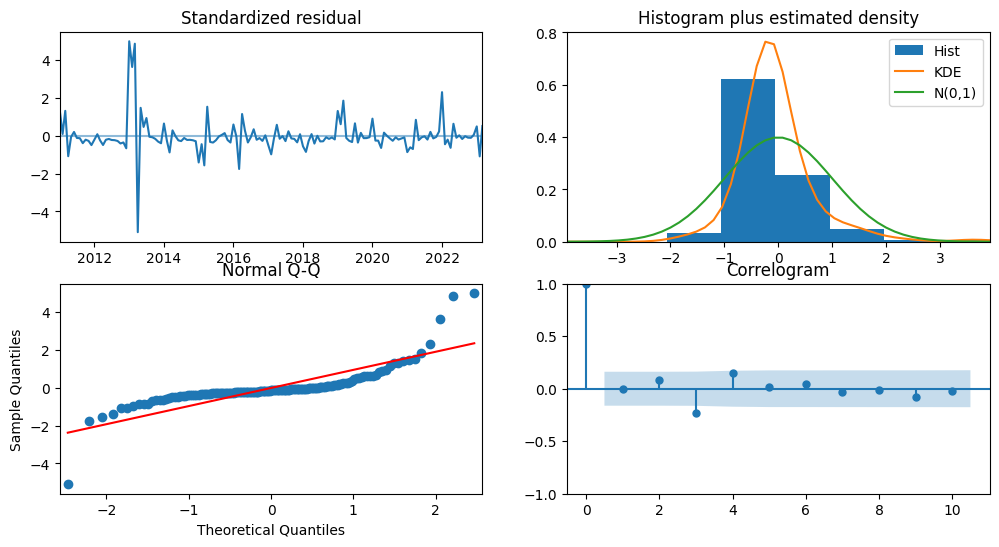

In [25]:
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(12,6));

In [26]:
#model = ARIMA(train["Cases"],order = (5,0,1))
model= ARIMA(train["Cases"], order=(0,0,5),seasonal_order=(3,0,3,12))
model = model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:                                    Cases   No. Observations:                  147
Model:             ARIMA(0, 0, 5)x(3, 0, [1, 2, 3], 12)   Log Likelihood               -1226.959
Date:                                  Fri, 19 Jul 2024   AIC                           2479.917
Time:                                          21:50:39   BIC                           2518.793
Sample:                                      01-01-2011   HQIC                          2495.713
                                           - 03-01-2023                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1426.3747   1053.985      1.353      0.176    -639.398    3492.147
ma.L1          1.1469      0.064     18.054      0.000       1.022       1.271
ma.L2          0.9373      0.069     13.678      0.000       0.803       1.072
ma.L3          0.3999      0.090      4.468      0.000       0.225       0.575
ma.L4          0.1222      0.203      0.601      0.548      -0.276       0.521
ma.L5          0.0235      0.195      0.121      0.904      -0.358       0.405
ar.S.L12       0.0179      0.237      0.076      0.940      -0.446       0.482
ar.S.L24      -0.1053      0.264     -0.399      0.690      -0.622       0.411
ar.S.L36       0.9403      0.160      5.873      0.000       0.626       1.254
ma.S.L12       0.0517      0.392      0.132      0.895      -0.717       0.820
ma.S.L24       0.2777      0.464      0.598      0.550      -0.633       1.188
ma.S.L36      -0.8067      0.327     -2.467      0.014      -1.448      -0.166
sigma2      1.118e+06      0.001   8.98e+08      0.000    1.12e+06    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):              1639.91
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             2.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+28. Standard errors may be unstable.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:                                    Cases   No. Observations:                  147
Model:             ARIMA(0, 0, 5)x(3, 0, [1, 2, 3], 12)   Log Likelihood               -1226.959
Date:                                  Fri, 19 Jul 2024   AIC                           2479.917
Time:                                          21:50:42   BIC                           2518.793
Sample:                                      01-01-2011   HQIC                          2495.713
                                           - 03-01-2023                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1426.3747   1053.985      1.353      0.176    -639.398    3492.147
ma.L1          1.1469      0.064     18.054      0.000       1.022       1.271
ma.L2          0.9373      0.069     13.678      0.000       0.803       1.072
ma.L3          0.3999      0.090      4.468      0.000       0.225       0.575
ma.L4          0.1222      0.203      0.601      0.548      -0.276       0.521
ma.L5          0.0235      0.195      0.121      0.904      -0.358       0.405
ar.S.L12       0.0179      0.237      0.076      0.940      -0.446       0.482
ar.S.L24      -0.1053      0.264     -0.399      0.690      -0.622       0.411
ar.S.L36       0.9403      0.160      5.873      0.000       0.626       1.254
ma.S.L12       0.0517      0.392      0.132      0.895      -0.717       0.820
ma.S.L24       0.2777      0.464      0.598      0.550      -0.633       1.188
ma.S.L36      -0.8067      0.327     -2.467      0.014      -1.448      -0.166
sigma2      1.118e+06      0.001   8.98e+08      0.000    1.12e+06    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):              1639.91
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             2.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+28. Standard errors may be unstable.
"""

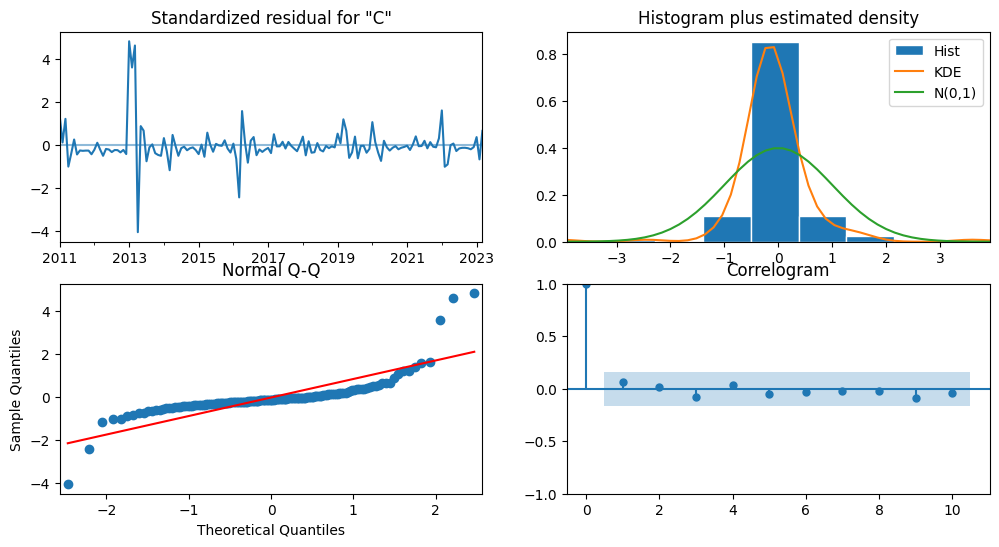

In [27]:
display(model.summary())
model.plot_diagnostics(figsize=(12,6));

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

error = model.resid
acorr = acorr_ljungbox(error)
print(acorr)

    lb_stat  lb_pvalue
1      0.77       0.38
2      0.98       0.61
3      2.24       0.52
4      2.38       0.67
5      2.71       0.74
6      2.95       0.81
7      3.04       0.88
8      3.15       0.92
9      4.39       0.88
10     4.65       0.91


In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lags = list(range(0, 13))
ljung_box_results = acorr_ljungbox(model.resid, lags=lags, return_df=True)

# Sonuçları yazdırma
print(ljung_box_results)

    lb_stat  lb_pvalue
0      4.73        NaN
1      0.77       0.38
2      0.98       0.61
3      2.24       0.52
4      2.38       0.67
5      2.71       0.74
6      2.95       0.81
7      3.04       0.88
8      3.15       0.92
9      4.39       0.88
10     4.65       0.91
11     4.66       0.95
12     4.73       0.97


In [29]:
prd = model.forecast(steps=len(test))
prd

2023-04-01   1673.57
2023-05-01   1422.19
2023-06-01   1055.80
2023-07-01    808.51
2023-08-01    732.62
2023-09-01    690.55
2023-10-01    679.71
2023-11-01    651.44
2023-12-01    647.39
2024-01-01   1145.90
2024-02-01   1103.04
2024-03-01    980.41
Freq: MS, Name: predicted_mean, dtype: float64

In [32]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(test["Cases"],prd))
#print('Test RMSE: %.4f' % error)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test["Cases"],prd)
#print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(test["Cases"],prd)
#print("Mean Squared Logarithmic Error (MSLE):", msle)

from sklearn.metrics import mean_absolute_percentage_error
#print('Mean Absolute Percentage Error (MAPE):',mean_absolute_percentage_error(valid["Cases"],predictions))

print('RMSE: %.2f' % error)
def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(test["Cases"],prd)
print(f"MAPE: {mape:.2f}%")
print('MAE:  %.2f' % mae)
print('MSLE: %.2f' % msle)

RMSE: 518.33
MAPE: 782.82%
MAE:  430.77
MSLE: 2.21


<Axes: xlabel='Date'>

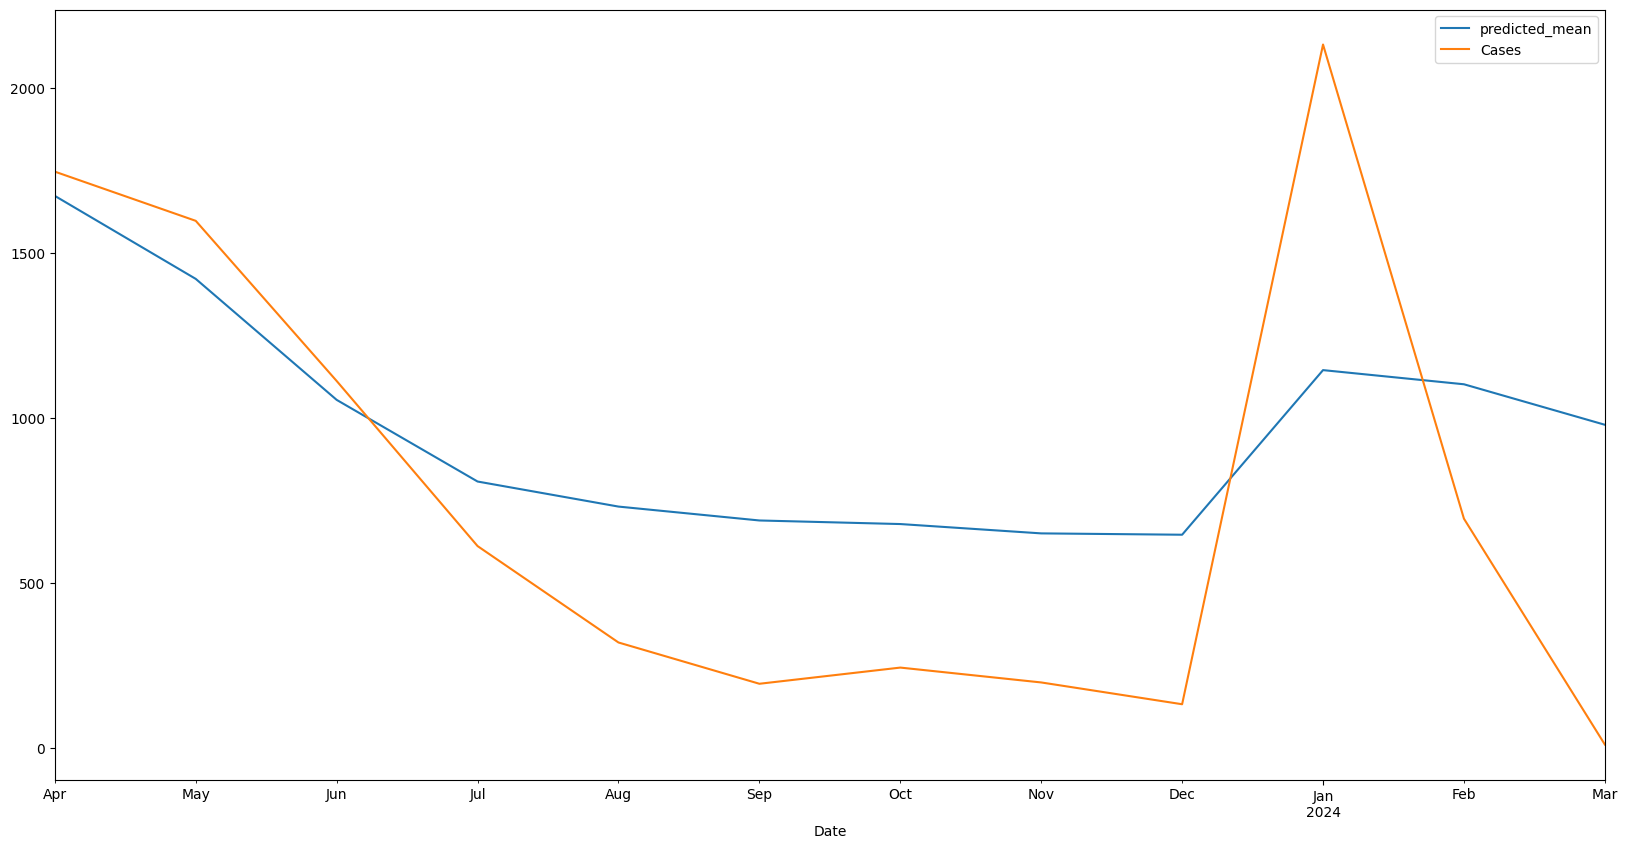

In [31]:
prd.plot(legend = True,figsize=(20,10))
test["Cases"].plot(legend = True)